# Make sure that i can reproduce the result from bertviz

In [41]:
import numpy as np
from dataProcessing import load_file, encode_data, insert_target, preProcessingScriber
import tensorflow as tf
import torch
from transformers import AutoTokenizer, TFCamembertForMaskedLM
from bertviz import head_view
import matplotlib.pyplot as plt

In [2]:
### instantiate the tokenizer
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-camembert-base", do_lower_case=True)

In [3]:
### path to weights
checkpointPath = "../project_PunctuatorBERTTensorFlow2/Models/20200512_083058/cp-010.ckpt"

In [4]:
### punctuation encoder
punctuation_enc = {
    'O': 0,
    'PERIOD': 1,
}

In [5]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [13]:
### hyperparameters
vocab_size = 32005
segment_size = 32
batch_size = 1

In [16]:
### get model
bertInp = tf.keras.Input(shape=(segment_size), dtype='int32', name='bertInp')
bertOut = TFCamembertForMaskedLM.from_pretrained("jplu/tf-camembert-base", output_attentions=True)(bertInp)
x = tf.keras.layers.Reshape((segment_size*vocab_size,))(bertOut[0])
denseOut = tf.keras.layers.Dense(2)(x)

model = tf.keras.Model(
    inputs = [bertInp],
    outputs = [bertOut, denseOut],
)

In [17]:
# load the weights
model.load_weights(checkpointPath)

### Input Sentence

In [18]:
# Faute de promulgation, la loi d'état d'urgence sanitaire partiellement applicable
string = "Faute de promulgation la loi d'état d'urgence sanitaire partiellement applicable"

# Because of his literary power and historical importance, Western literary critics consider him one of the great writers of world literature and among the creators of modern European writing
string = "because of his literary power and historical importance western literary critics consider him one of the great writers of world"

# Ecclésiastique et anticlérical, chrétien et considéré par certains comme libre penseur, médecin et ayant l'image d'un bon vivant, les multiples facettes de sa personnalité semblent parfois contradictoires. 
string = "ecclésiastique et anticlérical chrétien et considéré par certains comme libre penseur médecin et ayant l'image d'un bon vivant les multiples facettes de sa personnalité"

tokens = tokenizer.tokenize(string)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)

['▁ecclésiastique', '▁et', '▁anti', 'clé', 'r', 'ical', '▁chrétien', '▁et', '▁considéré', '▁par', '▁certains', '▁comme', '▁libre', '▁pense', 'ur', '▁médecin', '▁et', '▁ayant', '▁l', "'", 'image', '▁d', "'", 'un', '▁bon', '▁vivant', '▁les', '▁multiples', '▁facettes', '▁de', '▁sa', '▁personnalité']


In [19]:
len(ids)

32

In [20]:
print(ids)

[24920, 14, 896, 9440, 81, 6533, 8970, 14, 3523, 37, 420, 79, 1038, 500, 297, 1974, 14, 634, 17, 11, 1106, 18, 11, 59, 212, 2340, 19, 2523, 12098, 8, 77, 2810]


In [21]:
### pad the sequence
foo = []
foo.append(ids)
test = tf.keras.preprocessing.sequence.pad_sequences(foo, maxlen=32, padding='post')
print(test)

[[24920    14   896  9440    81  6533  8970    14  3523    37   420    79
   1038   500   297  1974    14   634    17    11  1106    18    11    59
    212  2340    19  2523 12098     8    77  2810]]


In [22]:
modelOut = model.predict(test)
bertOutput = modelOut[0]

In [23]:
# get the attention weights
attLayers = bertOutput[1]

In [26]:
# convert weights from np array to torch tensors
attention = []
for i in range(len(attLayers)):
    foo = torch.from_numpy(attLayers[i])
    attention.append(foo)

In [27]:
sequence = tokenizer.convert_ids_to_tokens(test[0])
print(sequence)

['▁ecclésiastique', '▁et', '▁anti', 'clé', 'r', 'ical', '▁chrétien', '▁et', '▁considéré', '▁par', '▁certains', '▁comme', '▁libre', '▁pense', 'ur', '▁médecin', '▁et', '▁ayant', '▁l', "'", 'image', '▁d', "'", 'un', '▁bon', '▁vivant', '▁les', '▁multiples', '▁facettes', '▁de', '▁sa', '▁personnalité']


In [28]:
head_view(attention, sequence)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visualize The Matrix

In [29]:
attentionWeights = bertOutput[1]

In [32]:
print(type(attentionWeights))
print(len(attentionWeights))

<class 'tuple'>
12


In [33]:
layerWeights = attentionWeights[0]

In [36]:
print(type(layerWeights))
print(layerWeights.shape)

<class 'numpy.ndarray'>
(1, 12, 32, 32)


In [38]:
headWeights = layerWeights[0, 4, :, :]

In [39]:
print(type(headWeights))
print(headWeights.shape)

<class 'numpy.ndarray'>
(32, 32)


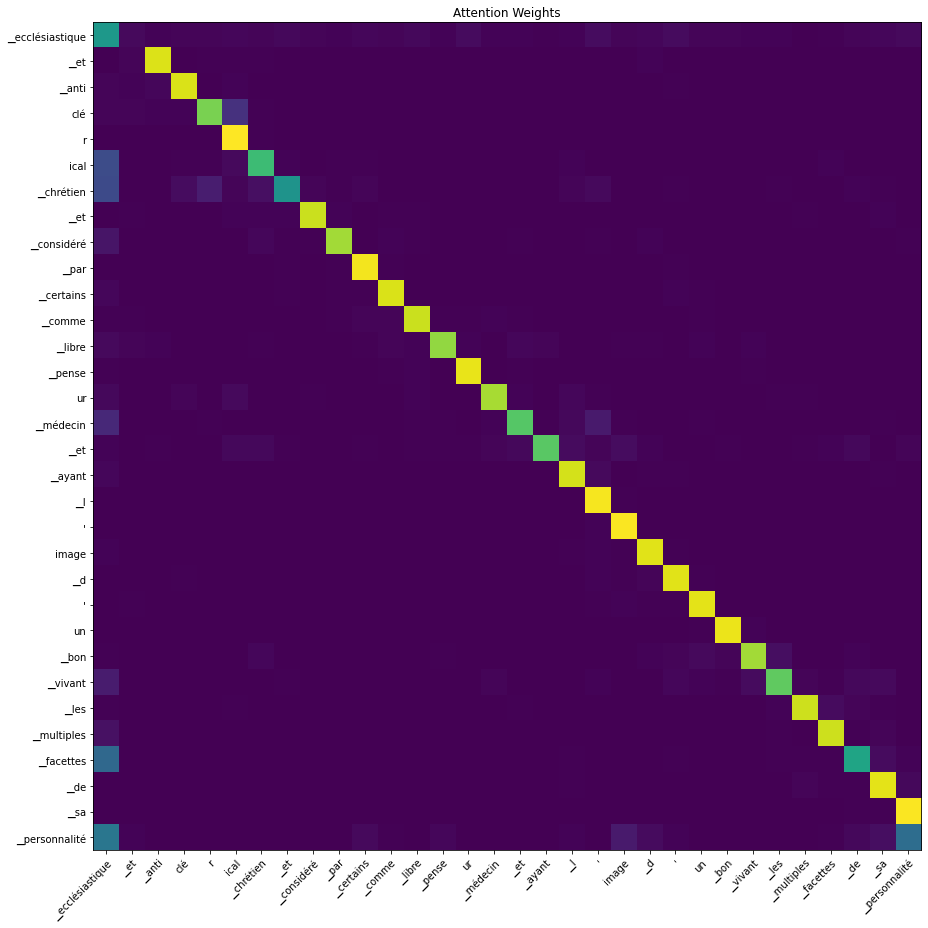

In [48]:
fig, ax = plt.subplots(figsize=(13, 13))
im = ax.imshow(headWeights)

# Show all ticks
ax.set_xticks(np.arange(len(sequence)))
ax.set_yticks(np.arange(len(sequence)))
# Label the ticks with the respective list entries
ax.set_xticklabels(sequence)
ax.set_yticklabels(sequence)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# # Loop over data dimensions and create text annotations.
# for i in range(len(sequence)):
#     for j in range(len(sequence)):
#         text = ax.text(j, i, headWeights[i, j],
#                        ha="center", va="center", color="w")

ax.set_title("Attention Weights")
fig.tight_layout()
plt.show()

### Visualize The Matrix For Another Head

In [49]:
layerWeights = attentionWeights[0]
headWeights = layerWeights[0, 3, :, :]

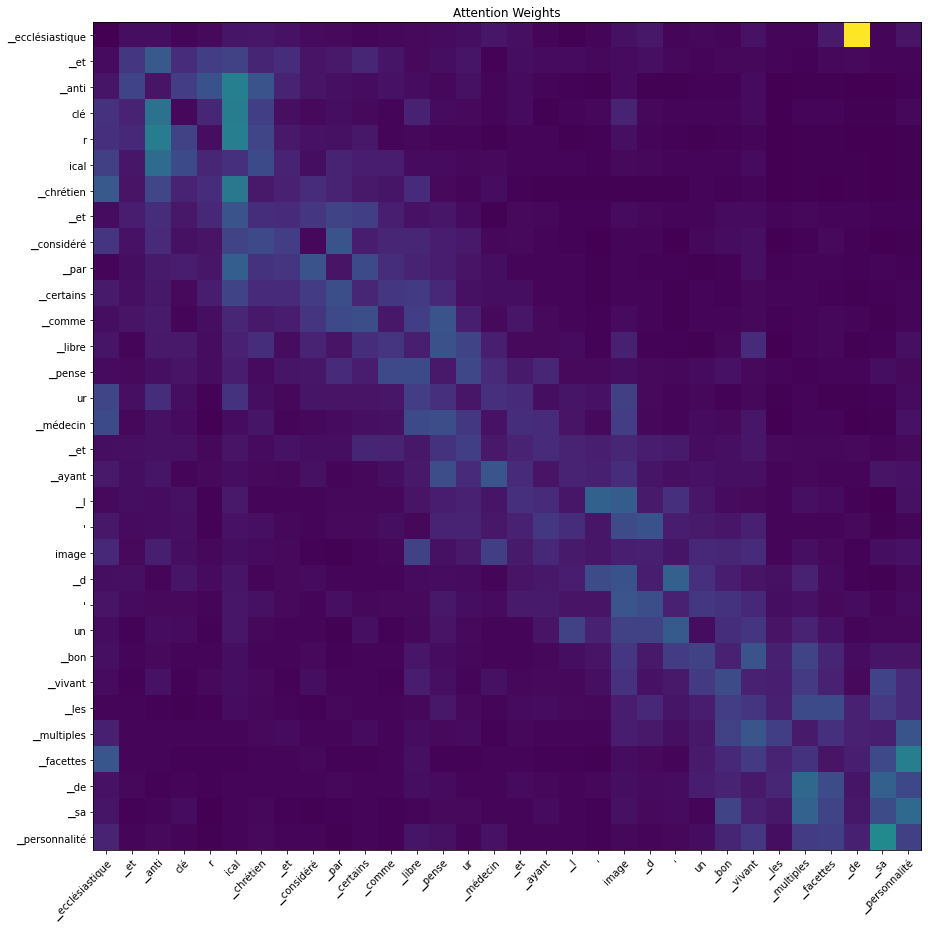

In [51]:
fig, ax = plt.subplots(figsize=(13, 13))
im = ax.imshow(headWeights)

# Show all ticks
ax.set_xticks(np.arange(len(sequence)))
ax.set_yticks(np.arange(len(sequence)))
# Label the ticks with the respective list entries
ax.set_xticklabels(sequence)
ax.set_yticklabels(sequence)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# # Loop over data dimensions and create text annotations.
# for i in range(len(sequence)):
#     for j in range(len(sequence)):
#         text = ax.text(j, i, headWeights[i, j],
#                        ha="center", va="center", color="w")

ax.set_title("Attention Weights")
fig.tight_layout()
plt.show()